In [1]:
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib as mpl 

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np
from jax import random 
from jax import grad, vmap, jit, lax

jax.config.update('jax_platform_name', 'cpu')

from functools import partial 

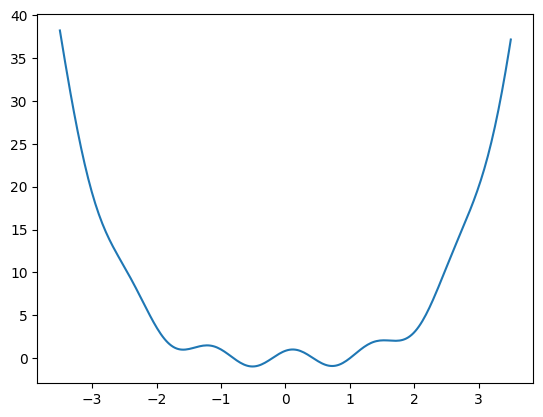

In [ ]:
def lennard_jones(r): 
    return (1/r)**12 - 2 * (1 / r)**6

@jax.jit
def lennard_jones_j(params): 
    r = params 
    return (1/r)**12 - 2 * (1 / r)**6

@jax.jit 
def grad_lj(params): 
    return jax.grad(lennard_jones_j)(params)

def osc_1d(x): 
    return x**4 / 4. + jnp.sin(1. + 5 * x)

@jax.jit
def osc_1d_j(x): 
    return x**4 / 4. + jnp.sin(1. + 5 * x)

@jax.jit 
def grad_osc1d_j(x): 
    # return jax.grad(osc_1d_j)(x)
    return x**3 + 5.*jnp.cos(1. + 5 * x)


In [5]:
from scipy.integrate import quad

a, b = -10.0, 10.0
Z, _ = quad(lambda x: np.exp(-osc_1d(x)), a, b)

M = 20
interval = (-3.5, 3.5)
bin_edges = np.linspace(*interval, M + 1)
exact_probs = np.zeros(M)

for i in range(M):
    lower, upper = bin_edges[i], bin_edges[i + 1]
    integral, _ = quad(lambda x: np.exp(-osc_1d(x)), lower, upper)
    exact_probs[i] = integral / Z

def compute_error(samples):
    observed_counts, _ = np.histogram(samples, bins=bin_edges)
    observed_probs = observed_counts / len(samples)
    return np.mean(np.abs(exact_probs - observed_probs))


In [3]:
@partial(jit, static_argnames=('n_steps',))
def obabo_langevin(key, x0, n_steps, h, gamma): 
    eta = jnp.exp(-h*gamma / 2.) 
    const_sqr = jnp.sqrt(1. - eta**2)

    key, subkey = jax.random.split(key) 
    v0 = jax.random.normal(subkey, x0.shape) 

    key, subkey1, subkey2 = jax.random.split(key, 3) 
    noise_keys0 = jax.random.split(subkey1, n_steps)
    noise_keys1 = jax.random.split(subkey2, n_steps)

    noises0 = const_sqr * jax.vmap(lambda k: jax.random.normal(k, x0.shape))(noise_keys0)
    noises1 = const_sqr * jax.vmap(lambda k: jax.random.normal(k, x0.shape))(noise_keys1)

    def step(carry, noises): 
        x, v = carry 
        noise0, noise1 = noises

        grad_U0 = grad_osc1d_j(x)
        
        # O step 
        vel0 = eta * v + noise0
        # B step 
        vel12 = vel0 - h / 2 * grad_U0 
        # A step 
        x1 = x + h * vel12
        # B step 
        grad_U1 = grad_osc1d_j(x1)

        vel1 = vel12 - h/2 * grad_U1
        # O step 
        vel_f = eta * vel1 + noise1 

        return (x1, vel_f), jnp.stack([x1, vel_f])
    
    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, (noises0, noises1))

    return samples 


@partial(jit, static_argnames=('n_steps',))
def baoab_langevin(key, x0, n_steps, h, gamma):
    eta = jnp.exp(-h * gamma)
    noise_scale = jnp.sqrt(1 - eta**2)
    
    key, subkey = random.split(key)
    v0 = random.normal(subkey, x0.shape)
    
    key, subkey = random.split(key)
    noise_keys = random.split(subkey, n_steps)
    noises = noise_scale * jax.vmap(lambda k: random.normal(k, x0.shape))(noise_keys)

    def step(carry, noise):
        x_prev, v_prev = carry
        
        # First B (half-step momentum update)
        grad_U_prev = grad_osc1d_j(x_prev)
        v_half = v_prev - 0.5 * h * grad_U_prev
        
        # First A (half-step position update)
        x_half = x_prev + 0.5 * h * v_half
        
        # O (full-step Ornstein-Uhlenbeck update)
        v_ou = eta * v_half + noise
        
        # Second A (half-step position update)
        x_new = x_half + 0.5 * h * v_ou
        
        # Second B (half-step momentum update)
        grad_U_new = grad_osc1d_j(x_new)
        v_new = v_ou - 0.5 * h * grad_U_new

        return (x_new, v_new), jnp.stack([x_new, v_new])

    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, noises)

    return samples

@partial(jit, static_argnames=('n_steps',))
def aboba_langevin(key, x0, n_steps, h, gamma):
    eta = jnp.exp(-h * gamma)
    noise_scale = jnp.sqrt(1 - eta**2)
    
    key, subkey = random.split(key)
    v0 = random.normal(subkey, x0.shape)
    
    key, subkey = random.split(key)
    noise_keys = random.split(subkey, n_steps)
    noises = noise_scale * jax.vmap(lambda k: random.normal(k, x0.shape))(noise_keys)

    def step(carry, noise):
        x_prev, v_prev = carry
        
        # First A (half-step position update)
        x_half = x_prev + 0.5 * h * v_prev

        # First B (half-step momentum update)
        grad_U_prev = grad_osc1d_j(x_prev)
        v_half = v_prev - 0.5 * h * grad_U_prev

        # O (full-step Ornstein-Uhlenbeck update)
        v_ou = eta * v_half + noise
        
        # Second B (half-step momentum update)
        grad_U_new = grad_osc1d_j(x_half)
        v_new = v_ou - 0.5 * h * grad_U_new

        # Second A (half-step position update)
        x_new = x_half + 0.5 * h * v_new

        return (x_new, v_new), jnp.stack([x_new, v_new])

    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, noises)

    return samples

In [5]:
key = jax.random.PRNGKey(123)
z0 = jnp.array([0.])
dt = 0.2 
tfinal = 10**6
gamma = 100.
n_steps = int(tfinal / dt)

samples_obabo = obabo_langevin(key, z0, n_steps, dt, gamma)
samples_baoab = baoab_langevin(key, z0, n_steps, dt, gamma)
samples_aboba = aboba_langevin(key, z0, n_steps, dt, gamma)


joint_samples_obabo = samples_obabo.reshape(n_steps, -1)
joint_samples_baoab = samples_baoab.reshape(n_steps, -1)
joint_samples_aboba = samples_aboba.reshape(n_steps, -1)


In [6]:
x_obabo = joint_samples_obabo[:, 0]
x_baoab = joint_samples_baoab[:, 0]
x_aboba = joint_samples_aboba[:, 0]

error_obabo = compute_error(x_obabo)
error_baoab= compute_error(x_baoab)
error_aboba = compute_error(x_aboba)

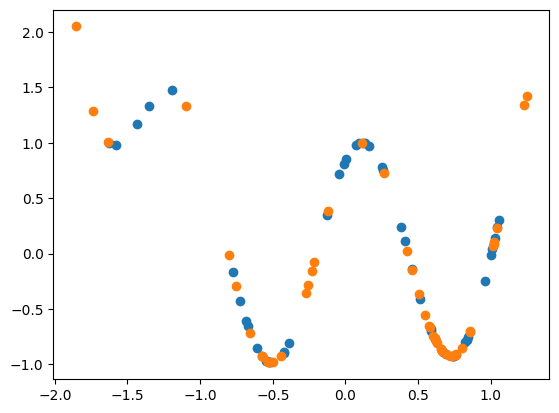

In [7]:
subsample = 10**5

plt.scatter(x_obabo[::subsample], osc_1d(x_obabo[::subsample]), )
plt.scatter(x_baoab[::subsample], osc_1d(x_baoab[::subsample]), )


In [9]:
import matplotlib as mpl 
mpl.style.use("seaborn-v0_8")
gamma = 1.
tfinal = 1e6
z0 = jnp.array([0.])
dt_values = jnp.linspace(0.05875, 0.4, 8, endpoint=False)

errors_obabo, errors_baoab, errors_aboba = [], [], []

key = jax.random.PRNGKey(123)
for dt in dt_values:
    n_steps = int(tfinal / dt)
    
    key, subkey_obabo = jax.random.split(key)
    key, subkey_baoab = jax.random.split(key)
    key, subkey_aboba = jax.random.split(key)
    
    samples_obabo = obabo_langevin(subkey_obabo, z0, n_steps, dt, gamma)
    samples_baoab = baoab_langevin(subkey_baoab, z0, n_steps, dt, gamma)
    samples_aboba = aboba_langevin(subkey_aboba, z0, n_steps, dt, gamma)
    
    errors_obabo.append(compute_error(samples_obabo[:, 0]))
    errors_baoab.append(compute_error(samples_baoab[:, 0]))
    errors_aboba.append(compute_error(samples_aboba[:, 0]))


In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax
import jax.numpy as jnp

from tqdm import tqdm 


mpl.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['font.size'] = 12

tfinal = 2e7
z0 = jnp.array([0.])
# dt_values = jnp.linspace(0.06, 0.4, 5, endpoint=False)
dt_values = jnp.linspace(0.15, 0.4, 5, endpoint=False)

gamma_values = [1., 40.]

results = {
    'ABOBA': [],
    'OBABO': [],
    'BAOAB': []
}

for gamma in gamma_values:
    gamma_errors = { 'ABOBA': [], 'OBABO': [], 'BAOAB': []} # 
    key = jax.random.PRNGKey(123)  
    
    for dt in tqdm(dt_values):
        n_steps = int(tfinal / dt)
        
        key, subkey_obabo = jax.random.split(key)
        key, subkey_baoab = jax.random.split(key)
        key, subkey_aboba = jax.random.split(key)
        
        samples_obabo = obabo_langevin(subkey_obabo, z0, n_steps, dt, gamma)
        samples_baoab = baoab_langevin(subkey_baoab, z0, n_steps, dt, gamma)
        samples_aboba = aboba_langevin(subkey_aboba, z0, n_steps, dt, gamma)
        
        gamma_errors['ABOBA'].append(compute_error(samples_aboba[:, 0]))
        gamma_errors['OBABO'].append(compute_error(samples_obabo[:, 0]))
        gamma_errors['BAOAB'].append(compute_error(samples_baoab[:, 0]))
    
    for method in results:
        results[method].append(gamma_errors[method])

print(results)


100%|██████████| 5/5 [02:39<00:00, 31.89s/it]

{'ABOBA': [[0.016288316092716543, 0.020165822054734727, 0.023132840754855104, 0.025524394712069833, 0.049925072463442036], [0.0014600732593340537, 0.002537747749542722, 0.003978476836861882, 0.005879219172373716, 0.0079377232160209]], 'OBABO': [[0.0030596837456715095, 0.0057898289046148105, 0.010229759464497588, 0.016861550115556057, 0.04255178642325972], [0.0036979948528298697, 0.006656788124119545, 0.010457069796666817, 0.014757921863036838, 0.019025720743960448]], 'BAOAB': [[0.0006134557990054289, 0.0012327213513001257, 0.002205569515646133, 0.004891383535645719, 0.010655665115655438], [9.252361465983943e-05, 0.00029337136189311927, 0.0007114866542810179, 0.0014834691321824705, 0.0029658912472532283]]}


### 1D potential 
$$
U(x) = \frac{x^4}{4} + \sin (1 + 5x).
$$

Text(0.5, 1.0, 'Potential $U(x) = \\frac{x^4}{4} + \\sin (1 + 5x)$')

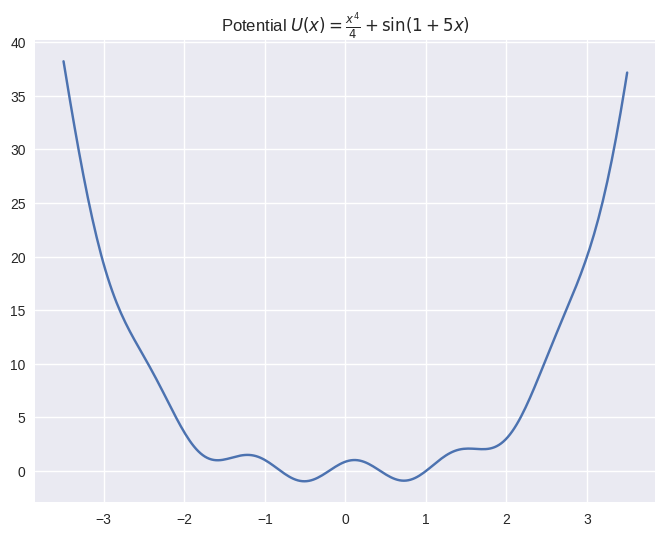

In [16]:

plt.figure(figsize=(8,6))

x = jnp.linspace(-3.5, 3.5, 256)

plt.plot(x, osc_1d(x))
plt.title(r"Potential $U(x) = \frac{x^4}{4} + \sin (1 + 5x)$")

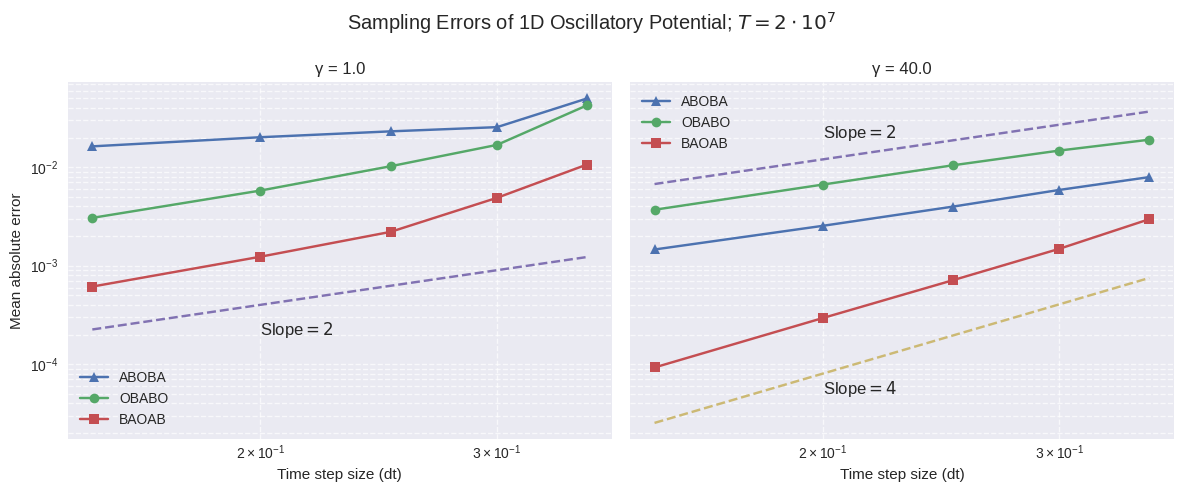

In [38]:
fig, ax = plt.subplots(1, 2, sharey=True)

for i, gamma in enumerate(gamma_values):
    ax[i].loglog(dt_values, results['ABOBA'][i], '^-', label='ABOBA')
    ax[i].loglog(dt_values, results['OBABO'][i], 'o-', label='OBABO')
    ax[i].loglog(dt_values, results['BAOAB'][i], 's-', label='BAOAB')
    
    ax[i].set_xlabel('Time step size (dt)')
    ax[i].set_title(f'γ = {gamma}')
    ax[i].grid(True, which='both', linestyle='--', alpha=0.7)
    ax[i].legend()

ax[0].set_ylabel('Mean absolute error')

ax[0].plot(dt_values, 1e-2*dt_values**2, '--')
ax[0].annotate(r"Slope$=2$", (0.2, 2e-4))

ax[1].plot(dt_values, 0.3*dt_values**2, '--')
ax[1].annotate(r"Slope$=2$", (0.2, 2.e-2))

ax[1].plot(dt_values, 5e-2*dt_values**4, '--')
ax[1].annotate(r"Slope$=4$", (0.2, 5e-5))

plt.suptitle(rf"Sampling Errors of 1D Oscillatory Potential; $T = 2\cdot 10^7$")
plt.tight_layout()
plt.show()